In [20]:
# !pip install opensmile

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import librosa
import librosa.display
import IPython.display as ipd
from datetime import datetime
import opensmile

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
np.random.seed(1)

In [6]:
def process_df(range, RAVDESS, dir_list):
  emotion = []
  path = []
  for i in range:
      directory = dir_list[i]
      fname = os.listdir(RAVDESS + directory)
      for f in fname:
          part = f.split('.')[0].split('-')
          emotion.append(int(part[2]))
          path.append(RAVDESS + directory + '/' + f)

  df = pd.DataFrame(emotion, columns=['label_class'])
  df['label'] = df['label_class'].replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
  df = pd.concat([df, pd.DataFrame(path, columns=['path'])], axis=1)
  df['label_class'] = df['label_class'] - 1
  return df

In [7]:
def fetch_dataset(path):
  RAVDESS = path+'/'
  dir_list = os.listdir(RAVDESS)
  dir_list.sort()

  # make train dataset
  df_train = process_df(range(22), RAVDESS, dir_list)

  # make test dataset
  df_test = process_df(range(22, 24), RAVDESS, dir_list)

  return df_train, df_test

In [8]:
df_train, df_test = fetch_dataset("/content/drive/MyDrive/wav2vec/RAVDESS/")

In [9]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

def get_features(path):
    result = smile.process_file(path)
    return result.iloc[0].tolist()

In [12]:
def get_features_df(df):
    X, Y = [], []

    for path, label in zip(df.path, df.label_class):
        feature = get_features(path)
        Y.append(label)
        X.append(feature)
    output_df = pd.DataFrame(X)
    output_df['labels'] = Y
    return output_df

In [13]:
train_df_with_f = get_features_df(df_train)
test_df_with_f = get_features_df(df_test)

In [14]:
def cross_val(model, label, train):
    start_time = datetime.now()
    kf = StratifiedKFold(n_splits = 4, shuffle=True, random_state=1)
    oof = np.full(len(train), np.nan)
    auc_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.labels)):
        X_tr = train.iloc[idx_tr]
        X_va = train.iloc[idx_va]
        y_tr = X_tr.pop('labels')
        y_va = X_va.pop('labels')
        model.fit(X_tr, y_tr)
#         print(np.round(model[-1].coef_, 2), np.round(model[-1].intercept_, 2))
        y_va_pred = model.predict(X_va)

        oof[idx_va] = y_va_pred
        auc = accuracy_score(y_va, y_va_pred)
        auc_list.append(auc)
    auc = np.array(auc_list).mean()
    execution_time = datetime.now() - start_time
    print(f"# AUC {auc:.5f}   time={str(execution_time)[-15:-7]}   {label}")
    return auc

# AUC 0.55682   time=0:00:20   RF min_samples_leaf=5
# AUC 0.53182   time=0:00:22   RF min_samples_leaf=10
# AUC 0.42576   time=0:00:10   RF min_samples_leaf=50
# AUC 0.36439   time=0:00:07   RF min_samples_leaf=100
# AUC 0.31364   time=0:00:04   RF min_samples_leaf=150
# AUC 0.29924   time=0:00:05   RF min_samples_leaf=200


Text(0.5, 1.0, 'RandomForestClassifier')

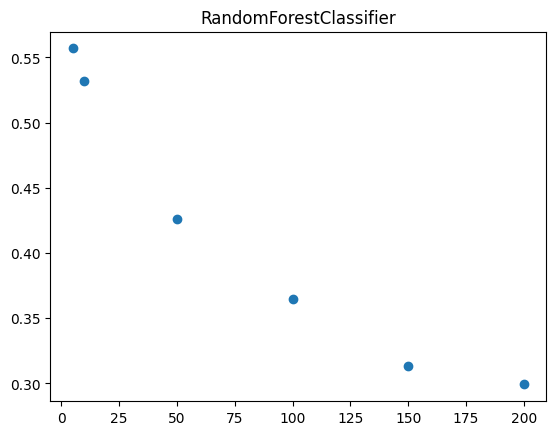

In [15]:
score_list = []
for min_samples_leaf in [5, 10, 50, 100, 150, 200]:
    auc = cross_val(RandomForestClassifier(n_estimators=100,
                                           min_samples_leaf=min_samples_leaf,
                                           max_features=1.0,
                                           random_state=1),
                    f"RF {min_samples_leaf=}", train_df_with_f)
    score_list.append((min_samples_leaf, auc))

plt.scatter(*zip(*score_list))
plt.title('RandomForestClassifier')

In [17]:
model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, max_features=1.0, random_state=1)
y = train_df_with_f.pop('labels')
model.fit(train_df_with_f, y)


RandomForestClassifier(max_features=1.0, min_samples_leaf=5, random_state=1)

In [19]:
y_test = test_df_with_f.pop('labels')
accuracy_score(y_test, model.predict(test_df_with_f))

0.525